[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/tspice/blob/main/examples/tidal_potential_indepth.ipynb)

# Tidal Gravitational Potential using `tSPICE`: In depth

This notebook demonstrates how to calculate the tidal potential generated by various celestial bodies at a specific location on Earth using `tSPICE`.

In [ ]:
try:
    from google.colab import drive
    %pip install -Uq git+https://github.com/DeivyMercado/TSPICE
    !mkdir -p ./gallery/
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2

Not running in Colab, skipping installation
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import package and initialize it (load data required for computations)

In [27]:
import tspice as tsp
import spiceypy as spy
from astropy.timeseries import LombScargle
import astropy.units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import cartopy.crs as ccrs
from datetime import datetime

tsp.initialize(level='full')
path = './gallery/'

TSPICE initialized successfully. Kernels loaded from: /Users/jzuluaga/dev/tspice/examples/tspice_data/meta_kernel


In [28]:
#Color palette
colors = ['#05668d', '#39a9ee', '#006400', "#38b000", '#ff6608', '#ff914d',
          '#a4161a', '#e5383b', '#5a189a', '#9d4edd', '#6f1d1b', '#bb9457']

#Planet color palette
body_colors = {
    'Moon': '#778899',    	#Gray
    'Sun': '#EE7733',     	#Vibrant Yellow/Orange
    'Mercury': '#0077BB', 	#Blue
    'Venus': '#33BBEE',   	#Cyan
    'Earth': '#009988',   	#Blue-Green (Teal)
    'Mars': '#CC3311',    	#Red
    'Jupiter': '#DDAA33', 	#Mustard Brown
    'Saturn': '#AA3377',  	#Purple
    'Uranus': '#66CCEE',  	#Light Cyan
    'Neptune': '#004488', 	#Navy Blue
}

## Tides on the Earth

In [29]:
#Create the object Body
earth = tsp.Body('Earth')

#Coordinates of the station in radians
loc = dict(lat = 4.49,
           lon = -73.14,
           depth = 0)	#Real depth 9km

#Dictionary with the start, stop, and step data ## Real time 13:08:05
date = dict(start = '2025-01-01 00:00:00',
            stop = '2026-01-01 00:00:00',
            step = '1h',
            time_frame = 'UTC')

#List of bodies to consider for tidal calculations
bodylist = ['Moon', 'Sun', 'Mercury', 'Venus', 'Mars', 'Jupiter']

#Get the tidal potential due just to the Moon
tgp_earth_tspice, et_utc = earth.tgp_many_bodies(bodylist, loc_sta=loc, dates=date, nmax=6, time_array=True, body_signal=False, verbose=False)

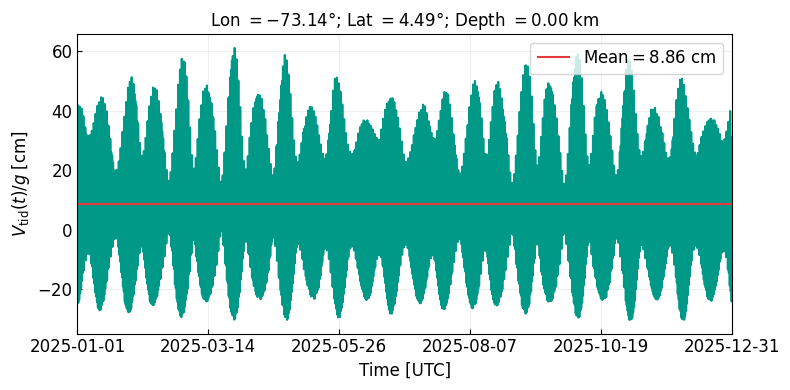

In [30]:
#Plotting the TSPICE signal
earth.plot_one_signal(et_utc, tgp_earth_tspice*100, loc, colors=[body_colors['Earth'], colors[7]], mean_value=True)

## Global distribution

In [31]:
#Create the main body object for Earth
earth = tsp.Body('EARTH')

#Coordinate mesh (10 degrees of resolution in every coordinate)
lat_s = np.linspace(-90, 90, 19)
lon_s = np.linspace(-180, 180, 37)
LAT_S, LON_S = np.meshgrid(lat_s,lon_s)
COLAT_S = 90-LAT_S
THETA_S, PHI_S = np.deg2rad(COLAT_S), np.deg2rad(LON_S)

#Diccionario de fechas --> One month of data with 1 hour step
date = dict(start="2025-01-01 00:00:00",
				stop="2025-01-29 00:00:00",
				step="1h",
                time_frame='UTC')

#List of bodies to consider for tidal calculations
bodylist = ['Moon', 'Sun']

#Get the total tidal signal due to all the bodies in the list
et_utc = earth.array_et_utc(date)
size_times = len(et_utc)

In [32]:
#Create an array to store the tidal potential values
tgp_earth_distr = np.zeros(LAT_S.shape + (size_times,), dtype=float)
np.shape(tgp_earth_distr)

(37, 19, 673)

In [33]:
#Calculation at every location on the meshgrid
for idx in np.ndindex(LAT_S.shape):
    loc_s = dict(lat = LAT_S[idx],
                 lon = LON_S[idx],
                 depth = 0.0)
    tgp_earth_distr[idx] = earth.tgp_many_bodies(bodylist, loc_sta=loc_s, dates=date, nmax=6, time_array=False, body_signal=False, verbose=False)


In [34]:
#Times
utc_times = spy.et2utc(et_utc, format_str='ISOC', prec=2)	#UTC strings
utc_times = [datetime.fromisoformat(utc) for utc in utc_times] #Datetime objects

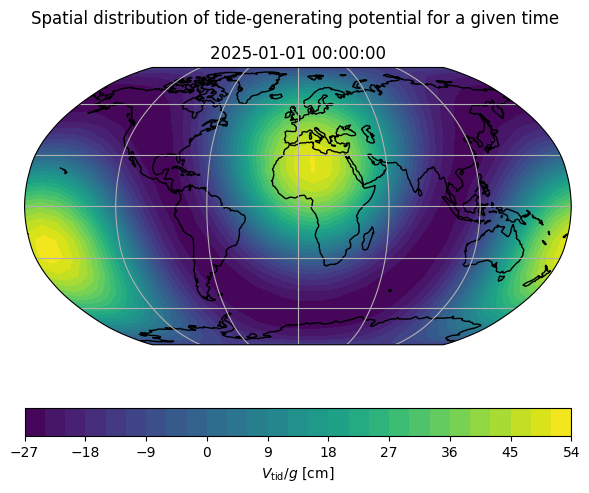

In [35]:
#Plot de los armónicos esféricos
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(6, 5))

idx = 0  #Index for time

#Setting the map
axs.set_global()
axs.coastlines()
axs.gridlines()

contour0 = axs.contourf(LON_S, LAT_S, tgp_earth_distr[:,:,idx]*100, transform=ccrs.PlateCarree(), levels=30, cmap='viridis')
axs.set_title(utc_times[idx], fontsize=12)
fig.colorbar(contour0, ax=axs, orientation='horizontal', label=r'$V_{\text{tid}}/g$ [cm]')

fig.suptitle('Spatial distribution of tide-generating potential for a given time', fontsize=12)
fig.tight_layout();

fig.savefig(path + 'tgp_earth_spatial_distribution.png', dpi=300)

In [36]:
#Minimum and maximum value of the potential to set the contours
tgp_earth_distr_cm = tgp_earth_distr*100  #Convert to cm
tgp_min, tgp_max = np.min(tgp_earth_distr_cm), np.max(tgp_earth_distr_cm)
levels = np.linspace(tgp_min, tgp_max, 30)

print(f'The minimun and maximun value of the potential are {tgp_min:.2f} and {tgp_max:.2f} m')

The minimun and maximun value of the potential are -28.34 and 55.49 m


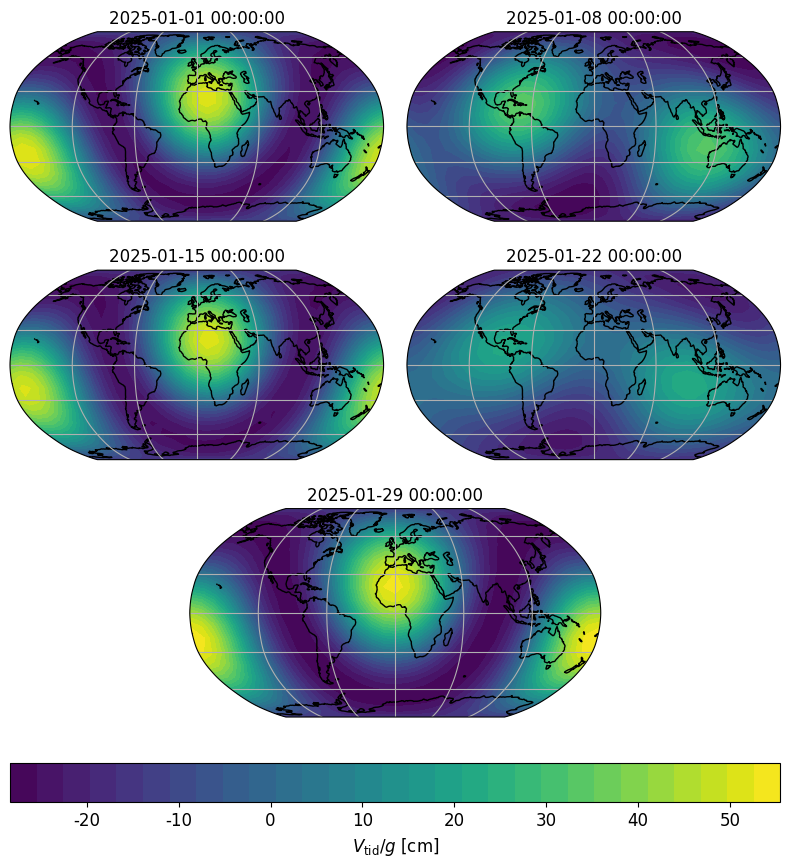

In [37]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(
    nrows=3, ncols=2,
    height_ratios=[1, 1, 1.1],
    hspace=0.25,
    wspace=0.05
)

#Subplots
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson())
ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.Robinson())
ax3 = fig.add_subplot(gs[1, 1], projection=ccrs.Robinson())
ax4 = fig.add_subplot(gs[2, :], projection=ccrs.Robinson())
axs = [ax0, ax1, ax2, ax3, ax4]

#Selected times
step_days = 7
idx = 24 * step_days * np.array([0, 1, 2, 3, 4])
ts = [utc_times[i] for i in idx]

#Plotting
for ax, i, t in zip(axs, idx, ts):
    ax.set_global()
    ax.coastlines()
    ax.gridlines()
    contour = ax.contourf(
        LON_S, LAT_S, tgp_earth_distr_cm[:, :, i],
        transform=ccrs.PlateCarree(),
        levels=levels,
        cmap='viridis',
        vmin=tgp_min,
        vmax=tgp_max
    )
    ax.set_title(t, fontsize=12)

#Colorbar
cbar = fig.colorbar(contour, ax=axs, orientation='horizontal', pad=0.06, fraction=0.05)
cbar.set_label(r'$V_{\text{tid}}/g$ [cm]', fontsize=12)
cbar.ax.tick_params(labelsize=12)
cbar.locator = ticker.MaxNLocator(nbins=10)
cbar.update_ticks()
cbar.ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

fig.savefig(path + 'TGP_earth_global_distribution.png', bbox_inches='tight', dpi=300)

## Tides on the Moon

In [38]:
#Create the object Body
moon = tsp.Body('Moon')

#Coordinates of the station in degrees and km (Tycho)
loc_moon1 = dict(lat = -43.30,
           lon = -73.14,
           depth = 0)

loc_moon2 = dict(lat = 43.30,
           lon = -73.14+180,
           depth = 0)

#Dictionary with the start, stop, and step data ## Real time 13:08:05
date_year = dict(start = '2025-01-01 00:00:00',
            stop = '2026-01-01 00:00:00',
            step = '1h',
            time_frame = 'UTC')

#List of bodies to consider for tidal calculations
bodylist_moon = ['Earth', 'Sun', 'Mercury', 'Venus', 'Mars', 'Jupiter']

#Get the tidal potential due just to the Moon
tgp_moon1, et_utc = moon.tgp_many_bodies(bodylist_moon, loc_sta=loc_moon1, dates=date_year, nmax=6, time_array=True, body_signal=False, verbose=False)
tgp_moon2, et_utc = moon.tgp_many_bodies(bodylist_moon, loc_sta=loc_moon2, dates=date_year, nmax=6, time_array=True, body_signal=False, verbose=False)

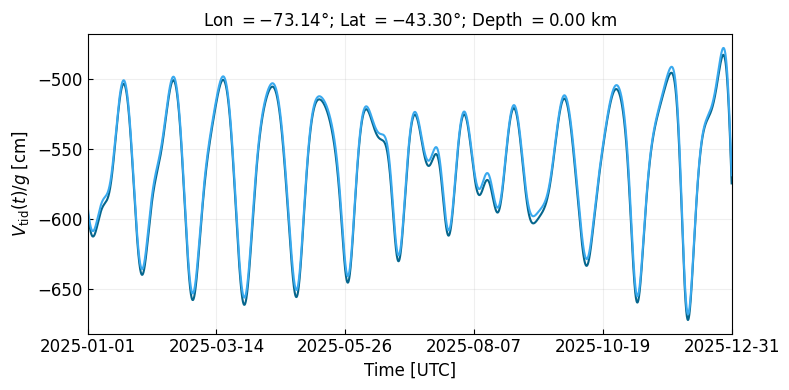

In [39]:
moon.plot_many_signal(et_utc, [tgp_moon1*100,tgp_moon2*100], loc=loc_moon1, units='cm', colors=[colors[0], colors[1]], y_label=r'V_{\text{tid}}(t)/g')

In [40]:
#Maximum 
delta_t = (1/24) #days
f_Nyq = (0.5/delta_t) #cycles per day
f_Nyq

12.0

In [41]:
from scipy.signal import find_peaks

#Times in days
t = (et_utc-et_utc.min())/(3600*24)	#Days

#Spectrum from ETERNA-x and TSPICE
frequency_moon, power_moon = LombScargle(t*u.day, tgp_moon1*u.m).autopower(maximum_frequency=0.2*u.day**-1)
amplitude_moon = (power_moon.value)**0.5
spectrum_moon = pd.DataFrame({'frequency (1/d)': frequency_moon.value,
                            'period (d)': 1/frequency_moon.value,
                            'power': power_moon.value,
							'amplitude': amplitude_moon})
spectrum_moon = spectrum_moon.sort_values(by='amplitude', ascending=False)

#Peaks in the spectrum
treshhold_amp = 0.06	#Threshold for the peaks in power
peaks_ind_moon = find_peaks(amplitude_moon, height=treshhold_amp, prominence=0.076)[0]#distance=10)[0]
peaks_freq_moon = spectrum_moon.loc[peaks_ind_moon,'frequency (1/d)'].values
peaks_power_moon = spectrum_moon.loc[peaks_ind_moon,'power'].values
peaks_amplitude_moon = spectrum_moon.loc[peaks_ind_moon,'amplitude'].values

print(f'Number of peaks {len(peaks_ind_moon)} in the Moon spectrum for a threshold of {treshhold_amp} in amplitude')

#Create a dataframe with the ETERNA-x peaks
peaks_moon = pd.DataFrame({'frequency (1/d)': peaks_freq_moon,
								  'period (d)': 1/peaks_freq_moon,
								  'power': peaks_power_moon,
								  'amplitude': peaks_amplitude_moon})
peaks_moon['period'] = 1/peaks_moon['frequency (1/d)']
peaks_moon = peaks_moon.sort_values(by='period', ascending=False, ignore_index=True)
peaks_moon


Number of peaks 6 in the Moon spectrum for a threshold of 0.06 in amplitude


,frequency (1/d),period (d),power,amplitude,period
0,0.004658,214.681373,0.010573,0.102827,214.681373
1,0.031510,31.735507,0.235218,0.484993,31.735507
2,0.035895,27.859415,0.740611,0.860587,27.859415
3,0.039731,25.169540,0.042412,0.205941,25.169540
4,0.067679,14.775641,0.079386,0.281756,14.775641
5,0.074255,13.467097,0.019392,0.139255,13.467097


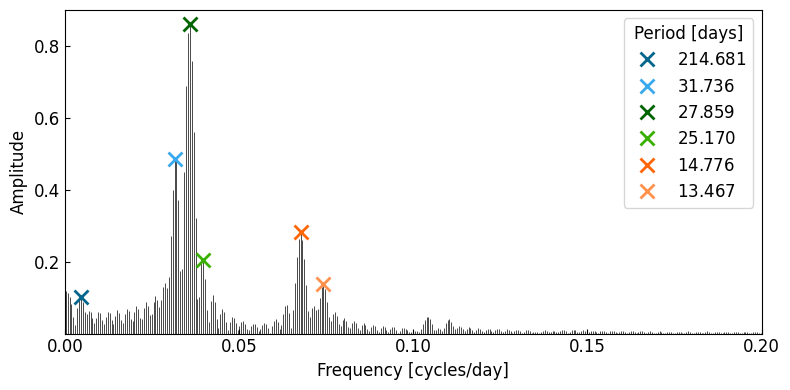

In [48]:
#Plot del espectro de la señal de mareas
fig, axs = plt.subplots(figsize=(8,4))
fs, amps = frequency_moon.value, amplitude_moon
axs.vlines(fs, np.zeros(len(fs)), amps, color='black', lw=0.5)

#Peaks
for i, (f, a, p) in enumerate(zip(peaks_moon['frequency (1/d)'], peaks_moon['amplitude'], peaks_moon['period'])):
  axs.plot(f, a,'x', color=colors[i], ms=10, mew=2, label=r'$%.3f$' %(p))

axs.set_xlabel('Frequency [cycles/day]', fontsize=12)
axs.set_ylabel('Amplitude', fontsize=12)
axs.set(xlim=(0,0.2), ylim=(0,0.9))
axs.xaxis.set_tick_params(direction='in', which='both', labelsize=12)
axs.yaxis.set_tick_params(direction='in', which='both', labelsize=12)
axs.set_xticks(np.linspace(0, 0.2, 5))
axs.set_yticks(np.linspace(0.2, 0.8, 4))

axs.legend(loc='best', ncols=1, fontsize=12, title='Period [days]', title_fontsize=12)

fig.tight_layout();
fig.savefig(path + 'moon_tides_spectrogram.png', dpi=300)

Font 'rm' does not have a glyph for '\t' [U+9], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\t' [U+9], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\t' [U+9], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\t' [U+9], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\t' [U+9], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\t' [U+9], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\t' [U+9], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\t' [U+9], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\t' [U+9], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\t' [U+9], substituting with a dummy symbol.


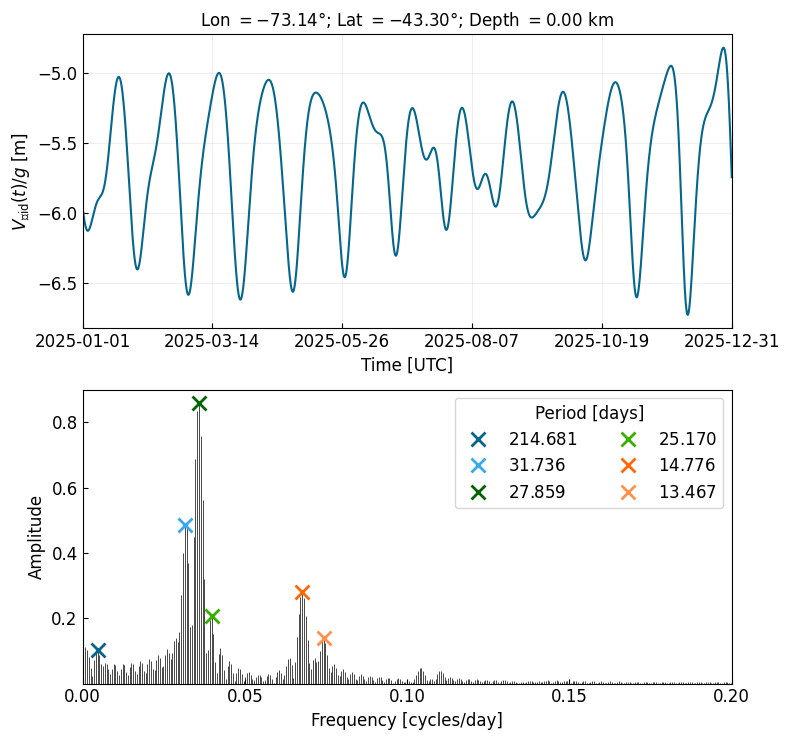

In [49]:
#Full plot + zoom
fig, axs = plt.subplots(2,1,figsize=(8,7.5))

#Times
utc_time = tsp.utils.et_to_utc_string(et_utc)
ticks = np.linspace(0, len(utc_time)-1, 6, dtype=int)

#Plot the tidal signals over time
ax0 = axs[0]
ax0.plot(utc_time, tgp_moon1, color=colors[0])
ax0.set_xlabel(r'Time [UTC]', fontsize=12)
ax0.set_ylabel(r'$V_{\text{\tid}}(t)/g$ [m]', fontsize=12)
ax0.set_title(r'Lon $= %.2f$°; Lat $= %.2f$°; Depth $= %.2f$ km' %(loc_moon1['lon'], loc_moon1['lat'], loc_moon1['depth']), fontsize=12)
ax0.set_xticks([utc_time[i] for i in ticks])
ax0.set_yticks(np.linspace(-6.5,-5, 4))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax0.xaxis.set_tick_params(direction='in', which='both', labelsize=12)
ax0.yaxis.set_tick_params(direction='in', which='both', labelsize=12)
ax0.grid(alpha=0.2)
ax0.margins(x=0)
#ax0.legend(fontsize=12, loc='best')

#Spectrum
ax1 = axs[1]
ax1.vlines(fs, np.zeros(len(fs)), amps, color='black', lw=0.5)
for i, (f, a, p) in enumerate(zip(peaks_moon['frequency (1/d)'], peaks_moon['amplitude'], peaks_moon['period'])):
  ax1.plot(f, a,'x', color=colors[i], ms=10, mew=2, label=r'$%.3f$' %(p))
ax1.set_xlabel('Frequency [cycles/day]', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set(xlim=(0,0.2), ylim=(0,0.9))
ax1.xaxis.set_tick_params(direction='in', which='both', labelsize=12)
ax1.yaxis.set_tick_params(direction='in', which='both', labelsize=12)
ax1.set_xticks(np.linspace(0, 0.2, 5))
ax1.set_yticks(np.linspace(0.2, 0.8, 4))
ax1.legend(loc='best', ncols=2, fontsize=12, title='Period [days]', title_fontsize=12)

fig.tight_layout();

fig.savefig(path + 'moon_tides.png', bbox_inches='tight', dpi=300)

## Io and Jupiter

Jupiter contribution calculated!
Europa contribution calculated!
Ganymede contribution calculated!
Callisto contribution calculated!
Sun contribution calculated!


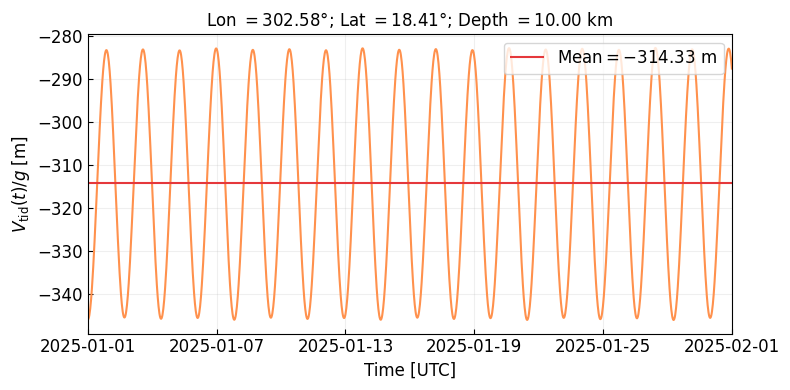

In [44]:
#Create the Body
io_jup = tsp.Body('Io')

#Eruptive center: Loki
loc_io = dict(lat = 18.41,
            	lon = 302.58,
                depth = 10.0)

#Dictionary with the start, stop, and step data ## Real time 13:08:05
date_month = dict(start = '2025-01-01 00:00:00',
            stop = '2025-02-01 00:00:00',
            step = '30m',
            time_frame = 'UTC')

#Galilean moons
jup_galilean_moons = ['Jupiter', 'Europa', 'Ganymede', 'Callisto', 'Sun']

#Calculate the potential
tgp_io_jup, et_io_month = io_jup.tgp_many_bodies(jup_galilean_moons, loc_io, date_month, nmax=6, time_array=True, body_signal=False)
io_jup.plot_one_signal(et_io_month, tgp_io_jup, loc_io, colors=[colors[5], colors[7]], units='m', mean_value=True)

In [45]:
#Times in days
t_io_jup = (et_io_month-et_io_month.min())/(3600*24)	#Days

#Spectrum from ETERNA-x and TSPICE
frequency_io_jup, power_io_jup = LombScargle(t_io_jup*u.day, tgp_io_jup*u.m).autopower(maximum_frequency=2*u.day**-1)
amplitude_io_jup = (power_io_jup.value)**0.5
spectrum_io_jup = pd.DataFrame({'frequency (1/d)': frequency_io_jup.value,
                            'period (d)': 1/frequency_io_jup.value,
                            'power': power_io_jup.value,
							'amplitude': amplitude_io_jup})
spectrum_io_jup = spectrum_io_jup.sort_values(by='amplitude', ascending=False)

#Peaks in the spectrum
treshhold_amp = 0.1	#Threshold for the peaks in power
peaks_ind_io_jup = find_peaks(amplitude_io_jup, height=treshhold_amp, prominence=0.2)[0]#distance=10)[0]
peaks_freq_io_jup = spectrum_io_jup.loc[peaks_ind_io_jup,'frequency (1/d)'].values
peaks_power_io_jup = spectrum_io_jup.loc[peaks_ind_io_jup,'power'].values
peaks_amplitude_io_jup = spectrum_io_jup.loc[peaks_ind_io_jup,'amplitude'].values

print(f'Number of peaks {len(peaks_ind_io_jup)} in the Moon spectrum for a threshold of {treshhold_amp} in amplitude')

#Create a dataframe with the ETERNA-x peaks
peaks_io_jup = pd.DataFrame({'frequency (1/d)': peaks_freq_io_jup,
								  'period (d)': 1/peaks_freq_io_jup,
								  'power': peaks_power_io_jup,
								  'amplitude': peaks_amplitude_io_jup})
peaks_io_jup['period'] = 1/peaks_io_jup['frequency (1/d)']
peaks_io_jup = peaks_io_jup.sort_values(by='period', ascending=False, ignore_index=True)
peaks_io_jup

Number of peaks 1 in the Moon spectrum for a threshold of 0.1 in amplitude


,frequency (1/d),period (d),power,amplitude,period
0,0.564516,1.771429,0.975521,0.987685,1.771429


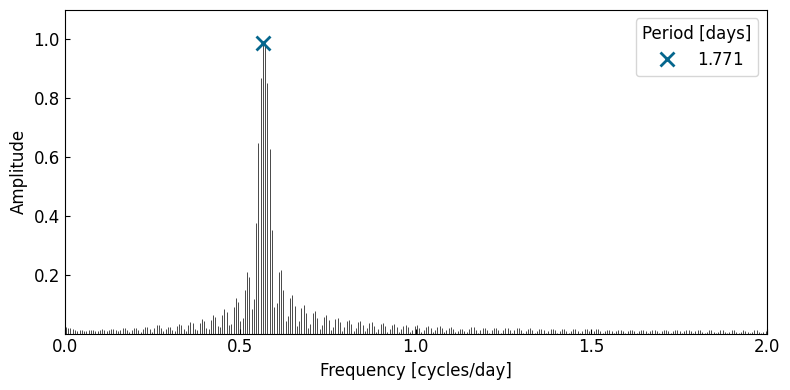

In [46]:
#Plot del espectro de la señal de mareas
fig, axs = plt.subplots(figsize=(8,4))
fs, amps = frequency_io_jup.value, amplitude_io_jup
axs.vlines(fs, np.zeros(len(fs)), amps, color='black', lw=0.5)

#Peaks
for i, (f, a, p) in enumerate(zip(peaks_io_jup['frequency (1/d)'], peaks_io_jup['amplitude'], peaks_io_jup['period'])):
  axs.plot(f, a,'x', color=colors[i], ms=10, mew=2, label=r'$%.3f$' %(p))

axs.set_xlabel('Frequency [cycles/day]', fontsize=12)
axs.set_ylabel('Amplitude', fontsize=12)
axs.set(xlim=(0,2), ylim=(0,1.1))
axs.xaxis.set_tick_params(direction='in', which='both', labelsize=12)
axs.yaxis.set_tick_params(direction='in', which='both', labelsize=12)
axs.set_xticks(np.linspace(0, 2, 5))
axs.set_yticks(np.linspace(0.2, 1.0, 5))

axs.legend(loc='best', ncols=2, fontsize=12, title='Period [days]', title_fontsize=12)

fig.tight_layout();

Font 'rm' does not have a glyph for '\t' [U+9], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\t' [U+9], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\t' [U+9], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\t' [U+9], substituting with a dummy symbol.


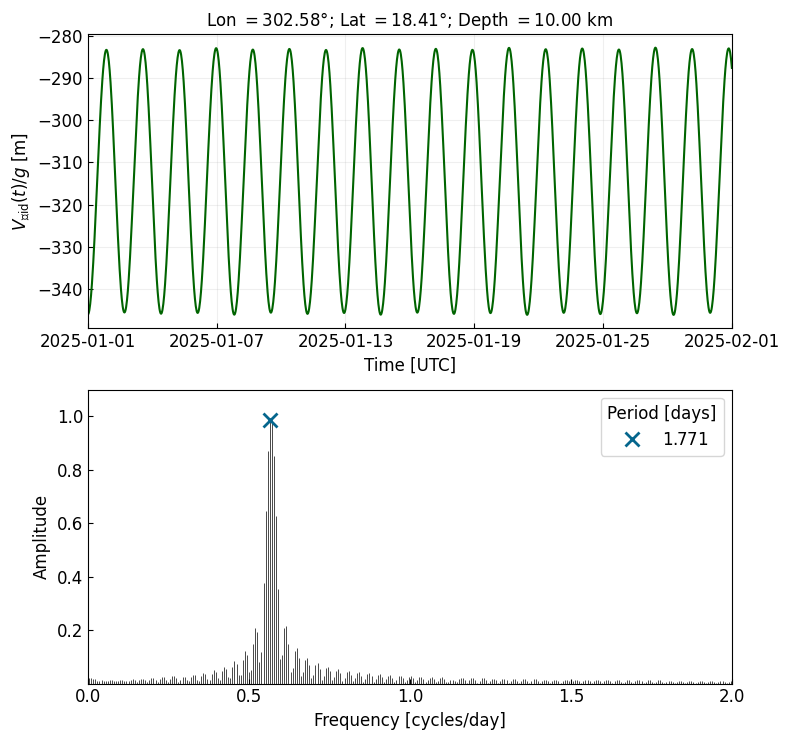

In [47]:
#Full plot + zoom
fig, axs = plt.subplots(2,1,figsize=(8,7.5))

#Times
utc_time = tsp.utils.et_to_utc_string(et_io_month)
ticks = np.linspace(0, len(utc_time)-1, 6, dtype=int)

#Plot the tidal signals over time
ax0 = axs[0]
ax0.plot(utc_time, tgp_io_jup, color=colors[2])
ax0.set_xlabel('Time [UTC]', fontsize=12)
ax0.set_ylabel(r'$V_{\text{\tid}}(t)/g$ [m]', fontsize=12)
ax0.set_title('Lon $= %.2f$°; Lat $= %.2f$°; Depth $= %.2f$ km' %(loc_io['lon'], loc_io['lat'], loc_io['depth']), fontsize=12)
ax0.set_xticks([utc_time[i] for i in ticks])
#ax0.set_yticks(np.linspace(-6.5,-5, 4))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax0.xaxis.set_tick_params(direction='in', which='both', labelsize=12)
ax0.yaxis.set_tick_params(direction='in', which='both', labelsize=12)
ax0.grid(alpha=0.2)
ax0.margins(x=0)
#ax0.legend(fontsize=12, loc='best')

#Spectrum
ax1 = axs[1]
fs, amps = frequency_io_jup.value, amplitude_io_jup
ax1.vlines(fs, np.zeros(len(fs)), amps, color='black', lw=0.5)
for i, (f, a, p) in enumerate(zip(peaks_io_jup['frequency (1/d)'], peaks_io_jup['amplitude'], peaks_io_jup['period'])):
  ax1.plot(f, a,'x', color=colors[i], ms=10, mew=2, label=r'$%.3f$' %(p))
ax1.set_xlabel('Frequency [cycles/day]', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set(xlim=(0,2), ylim=(0,1.1))
ax1.xaxis.set_tick_params(direction='in', which='both', labelsize=12)
ax1.yaxis.set_tick_params(direction='in', which='both', labelsize=12)
ax1.set_xticks(np.linspace(0, 2, 5))
ax1.set_yticks(np.linspace(0.2, 1.0, 5))
ax1.legend(loc='best', ncols=1, fontsize=12, title='Period [days]', title_fontsize=12)

fig.tight_layout();

#Save figure
#fig.savefig(path + 'Io_results.pdf', format='pdf', bbox_inches='tight', dpi=300)

---
*Powered by tSPICE*. For more examples see [tSPICE GitHub repo](https://github.com/DeivyMercado/TSPICE/tree/main/examples). 

**Copyright**: 2026, Deivy Mercado, Jorge I. Zuluaga, Gloria Moncayom